In [1]:
import os
import pandas as pd
import numpy as np
import climate_econometrics_toolkit.user_api as api
import math
import random
import matplotlib.pyplot as plt
import geopandas as gpd
import subprocess
from osgeo import gdal

/home/hayden-freedman/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/hayden-freedman/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
cet_home = os.getenv("CETHOME")
reproduction_dir = cet_home + "/ortiz_bobea_reproduction/"
gcm_data_dir = f"{reproduction_dir}/gcms/"
num_bootstrap_samples = 500
gcm_dir = cet_home + "/processed_gcm_data/"

# Build model with CET

In [3]:
api.load_dataset_from_file("../data/ortiz_bobea_data.csv")
api.set_time_column("year")
api.set_panel_column("ISO3")

INFO: Loading dataset ../data/ortiz_bobea_data.csv as active dataset and resetting current model.


In [4]:
# construct model
api.set_target_variable("fd_log_tfp")
api.add_covariates(["fd_tmean","fd_tmean_sq","fd_prcp","fd_prcp_sq"])
api.add_fixed_effects(["year","ISO3"])

In [5]:
api.view_current_model()

target_var : fd_log_tfp
covariates : ['fd_tmean', 'fd_tmean_sq', 'fd_prcp', 'fd_prcp_sq']
fixed_effects : ['year', 'ISO3']
random_effects : None
time_trends : []
time_column : year
panel_column : ISO3
out_sample_mse : nan
out_sample_mse_reduction : nan
out_sample_pred_int_cov : nan
r2 : nan
rmse : nan
model_id : None


In [6]:
model_id = api.evaluate_model_with_OLS()

INFO: Evalating non-random-effects model using standard error type 'nonrobust'
INFO: Demeaning applied: True


/home/hayden-freedman/.local/lib/python3.10/site-packages/pyfixest/estimation/demean_.py:229: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  n_threads = nb.get_num_threads()


INFO: Splitting data using technique 'random' with 10 cross-validation folds.
                    Coef.      Std.Err.             t         P>|t|  \
const        2.005774e-18  8.533197e-04  2.350554e-15  1.000000e+00   
fd_tmean    -6.475999e-03  4.615034e-03 -1.403240e+00  1.605789e-01   
fd_tmean_sq -4.752681e-05  1.222550e-04 -3.887514e-01  6.974690e-01   
fd_prcp      1.816850e-04  3.335915e-05  5.446332e+00  5.273709e-08   
fd_prcp_sq  -1.818987e-07  4.081797e-08 -4.456340e+00  8.435169e-06   

                   [0.025        0.975]  
const       -1.672695e-03  1.672695e-03  
fd_tmean    -1.552248e-02  2.570485e-03  
fd_tmean_sq -2.871736e-04  1.921200e-04  
fd_prcp      1.162937e-04  2.470763e-04  
fd_prcp_sq  -2.619110e-07 -1.018865e-07  
INFO: Model assigned ID: 1750282709.0485594


# Bootstrap model for coefficient samples

In [15]:
api.run_block_bootstrap(api.get_model_by_id(model_id), num_samples=num_bootstrap_samples)

INFO: Loading model from cache with ID '1750267654.5413082'
INFO: Bootstrapping may run for awhile. See progress bar on command line for updates.


100% (500 of 500) |######################| Elapsed Time: 0:41:26 Time:  0:41:262422


1750267654.5413082

# Preprocess GCM data

In [5]:
# remove some non-populated areas from shape file
areas_to_remove = ["BV","JN","SV","DQ","FQ","HQ","JQ","MQ","WQ","JU","GO","WE","GZ"]
raster = gpd.read_file(f"{reproduction_dir}/country_shapes/country.shp")
raster2 = raster.loc[~raster.FIPS_CNTRY.isin(areas_to_remove)]
raster2 = gpd.GeoDataFrame(raster2)
raster2.to_file(f"{reproduction_dir}/country_shapes/country2.shp")
shape_file = reproduction_dir + "/country_shapes/country2.shp"

In [41]:
# shift climate raster data to correct scale
def create_shifted_file(filename, new_filename):
    cdo_command = ["cdo","sellonlatbox,-180,180,-90,90",filename,gcm_data_dir + "/" + gcm + "/" + new_filename]
    subprocess.run(cdo_command)

for gcm in os.listdir(gcm_data_dir):
    for file in os.listdir(gcm_data_dir + "/" + gcm):
        filename_segs = file.split(".")[0:-1]
        filename_segs.append("shifted")
        filename_segs.append("nc")
        new_filename = ".".join(filename_segs)
        if "shifted" not in file and not os.path.exists(gcm_data_dir + "/" + gcm + "/" + new_filename):
            if file.endswith(".nc"):
                create_shifted_file(gcm_data_dir + "/" + gcm + "/" + file, new_filename)

cdo    sellonlatbox: Processed 33816576 values from 1 variable over 1032 timesteps [1.26s 782MB].
cdo    sellonlatbox: Processed 21250944 values from 1 variable over 1032 timesteps [0.83s 782MB].
cdo    sellonlatbox: Processed 21250944 values from 1 variable over 1032 timesteps [0.84s 782MB].
cdo    sellonlatbox: Processed 21250944 values from 1 variable over 1032 timesteps [1.07s 782MB].
cdo    sellonlatbox: Processed 8454144 values from 1 variable over 1032 timesteps [0.69s 782MB].
cdo    sellonlatbox: Processed 8454144 values from 1 variable over 1032 timesteps [0.76s 782MB].
cdo    sellonlatbox: Processed 8454144 values from 1 variable over 1032 timesteps [0.58s 782MB].
cdo    sellonlatbox: Processed 11612160 values from 1 variable over 420 timesteps [1.34s 782MB].
cdo    sellonlatbox: Processed 11612160 values from 1 variable over 420 timesteps [0.59s 782MB].
cdo    sellonlatbox: Processed 11612160 values from 1 variable over 420 timesteps [0.59s 782MB].
cdo    sellonlatbox: Proce

In [42]:
# get greenest months for each country
green_months = {}
green_month_data = pd.read_csv(reproduction_dir + "/peak_bottom_ndvi_month_country.csv")
for row in green_month_data.itertuples():
    peak = row[5]
    season = [i for i in range(peak-2,peak+3)]
    for i in range(len(season)):
        if season[i] < 1:
            season[i] = season[i] + 12
        elif season[i] > 12:
            season[i] = season[i] - 12
    green_months[row.ISO3] = season

In [43]:
# process GCM data
for gcm in os.listdir(gcm_data_dir):
    for file in os.listdir(gcm_data_dir + "/" + gcm):
        if file.endswith(".shifted.nc"):
            filename = "aggregated_" + file.replace(".nc",".csv")
            save_dir = cet_home + "/processed_gcm_data/" + gcm + "/crop_weighted/"
            if not os.path.isfile(save_dir + "/" + filename):
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                filepath = gcm_data_dir + "/" + gcm + "/" + file
                var_name = file.split("_")[0]
                func = "sum" if var_name == "pr" else "mean"
                first_year_in_data = int(file.split("_")[-1].split("-")[0][0:4])
                raster = gdal.Open(filepath)
                weight_file = reproduction_dir + f"/weight_files/Cropland2000_5m.tif"
                if "historical" in file:
                    grouping = "historical"
                elif "hist-nat" in file:
                    grouping = "hist-nat"
                print(file, filepath, shape_file, weight_file, first_year_in_data, func, var_name)
                out = api.extract_raster_data(filepath, shape_file=shape_file, weight_file=weight_file)
                data = api.aggregate_raster_data_to_year_level(out, var_name, "mean", 12, first_year_in_data, shape_file=shape_file, geo_identifier="GMI_CNTRY", subperiods_to_use=green_months)
                data.to_csv(save_dir + filename)

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


tasmax_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/tasmax_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/tasmax_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resa

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/pr_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/pr_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/tasmin_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CNRM/tasmin_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmax_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/tasmax_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/tasmax_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolki

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/tasmin_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/tasmin_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolki

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/pr_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//IPSL/pr_Amon_IPSL-CM6A-LR_ssp245_r1i1p1f1_gr_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raste

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmax_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/tasmax_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/tasmax_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/tasmin_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/tasmin_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/pr_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//CanESM5/pr_Amon_CanESM5_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/pr_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/pr_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmax_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/tasmax_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/tasmax_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econ

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/tasmin_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//HadGEM3/tasmin_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econ

/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/pr_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/pr_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])
Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


tasmax_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmax_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmax_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])
Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


tasmax_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmax_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmax_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resamp

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmin_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmin_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])
Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


pr_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/pr_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/pr_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmin_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MRI/tasmin_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmax_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/tasmax_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/tasmax_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


pr_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/pr_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/pr_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


tasmin_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/tasmin_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//MIROC6/tasmin_Amon_MIROC6_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_files/Cropland2000_5m_resampled.tif


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


tasmin_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/tasmin_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmin
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/tasmin_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/res

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


tasmax_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/tasmax_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 mean tasmax
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/tasmax_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/res

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


pr_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/pr_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif 2015 sum pr
INFO: Extracting raster data using raster_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//gcms//BCC/pr_Amon_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_201501-210012.shifted.nc; shape_file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//country_shapes/country2.shp; weights file /home/hayden-freedman/climate_econometrics_toolkit/ortiz_bobea_reproduction//weight_files/Cropland2000_5m.tif.
INFO: Resampled weights file has been saved to /home/hayden-freedman/climate_econometrics_toolkit/resampled_raster_fil

Warning 1: Latitude grid not spaced evenly.  Setting projection for grid spacing is within 0.1 degrees threshold.


INFO: Aggregating raster data using function mean


/home/hayden-freedman/.local/lib/python3.10/site-packages/climate_econometrics_toolkit/raster_extraction.py:130: RuntimeWarning: Mean of empty slice
  data.append([geo, period, np.nanmean(agg_mean)])


In [44]:
# Historical climate means
country_climate_means = {}
country_1961_means = {}
ccm_file = pd.read_csv(f"{reproduction_dir}/country_climate_means.csv")
for row in ccm_file.itertuples():
    country_climate_means[row[2]] = {"mean_temp":row[3], "mean_prcp":row[4]}
c1961_file = pd.read_csv(f"{reproduction_dir}/country_climate_1961.csv")
for row in c1961_file.itertuples():
    country_1961_means[row[2]] = {"mean_temp":row[6],"mean_prcp":row[4]}

In [66]:
# Concatenate historical and projected data
for var in ["tasmax","tasmin","pr"]:
    for gcm in os.listdir(gcm_dir):
        file_dir = gcm_dir + gcm + "/crop_weighted/"
        filename = [file for file in os.listdir(file_dir) if "historical" in file and var in file][0]
        hist_file = pd.read_csv(file_dir + "/" + filename)
        ssp245_file = pd.read_csv(file_dir + "/" + [file for file in os.listdir(file_dir) if "ssp245" in file and var in file][0])
        concatenated = pd.concat([hist_file, ssp245_file]).sort_values(["GMI_CNTRY","year"]).reset_index(drop=True).to_csv(file_dir + "/concatenated/concat_" + filename)
        if gcm == "MRI":
            filename = f"aggregated_{var}_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_185001-202012.shifted.csv"
            hist_nat1 = pd.read_csv(file_dir + f"/aggregated_{var}_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_185001-201412.shifted.csv")
            hist_nat2 = pd.read_csv(file_dir + f"/aggregated_{var}_Amon_MRI-ESM2-0_hist-nat_r1i1p1f1_gn_201501-202012.shifted.csv")
            concatenated = pd.concat([hist_nat1, hist_nat2]).sort_values(["GMI_CNTRY","year"]).reset_index(drop=True).to_csv(file_dir + "/concatenated/concat_" + filename)

In [89]:
# make climate diff data
temp_hist_dev, temp_nat_dev, prcp_hist_dev, prcp_nat_dev = {}, {}, {}, {}
t1, t2, p1, p2 = {}, {}, {}, {}
t_diff, t_2_diff, p_diff, p_2_diff, = {}, {}, {}, {}

for gcm in os.listdir(gcm_dir):
    file_dir = gcm_dir + gcm + "/crop_weighted/"
    for file in os.listdir(file_dir):
        if file.endswith("shifted.csv"):
            if "tasmax" in file and "hist-nat" in file:
                tasmax_hist_nat = pd.read_csv(file_dir + "/" + file)
            elif "tasmin" in file and "hist-nat" in file:
                tasmin_hist_nat = pd.read_csv(file_dir + "/" + file)
            elif "pr" and "hist-nat" in file:
                pr_hist_nat = pd.read_csv(file_dir + "/" + file)
            elif "tasmax" in file and "historical" in file:
                tasmax_hist = pd.read_csv(file_dir + "/" + file)
            elif "tasmin" in file and "historical" in file:
                tasmin_hist = pd.read_csv(file_dir + "/" + file)
            elif "pr" in file and "historical" in file:
                pr_hist = pd.read_csv(file_dir + "/" + file)
    
    tasmin_hist_nat = tasmin_hist_nat.loc[(tasmin_hist_nat.year <= 2020) & (tasmin_hist_nat.year >= 1961)]
    tasmin_hist = tasmin_hist.loc[(tasmin_hist.year <= 2020) & (tasmin_hist.year >= 1961)]
    tasmax_hist_nat = tasmax_hist_nat.loc[(tasmax_hist_nat.year <= 2020) & (tasmax_hist_nat.year >= 1961)]
    tasmax_hist = tasmax_hist.loc[(tasmax_hist.year <= 2020) & (tasmax_hist.year >= 1961)]
    pr_hist_nat = pr_hist_nat.loc[(pr_hist_nat.year <= 2020) & (pr_hist_nat.year >= 1961)]
    pr_hist = pr_hist.loc[(pr_hist.year <= 2020) & (pr_hist.year >= 1961)]

    tasmin_hist_nat = tasmin_hist_nat.loc[tasmin_hist_nat.GMI_CNTRY.isin(country_climate_means)]
    tasmin_hist = tasmin_hist.loc[tasmin_hist.GMI_CNTRY.isin(country_climate_means)]
    tasmax_hist_nat = tasmax_hist_nat.loc[tasmax_hist_nat.GMI_CNTRY.isin(country_climate_means)]
    tasmax_hist = tasmax_hist.loc[tasmax_hist.GMI_CNTRY.isin(country_climate_means)]
    pr_hist_nat = pr_hist_nat.loc[pr_hist_nat.GMI_CNTRY.isin(country_climate_means)]
    pr_hist = pr_hist.loc[pr_hist.GMI_CNTRY.isin(country_climate_means)]

    tmean_hist_nat = pd.DataFrame()
    tmean_hist_nat["GMI_CNTRY"] = tasmin_hist_nat["GMI_CNTRY"]
    tmean_hist_nat["year"] = tasmin_hist_nat["year"]
    tmean_hist_nat["tmean"] = np.nanmean([tasmin_hist_nat.tasmin, tasmax_hist_nat.tasmax], axis=0) - 273.15
    
    tmean_hist = pd.DataFrame()
    tmean_hist["GMI_CNTRY"] = tasmin_hist["GMI_CNTRY"]
    tmean_hist["year"] = tasmin_hist["year"]
    tmean_hist["tmean"] = np.nanmean([tasmin_hist.tasmin, tasmax_hist.tasmax], axis=0) - 273.15

    tmean_hist["tmean"] = [(row.tmean - country_climate_means[row.GMI_CNTRY]["mean_temp"]) + country_1961_means[row.GMI_CNTRY]["mean_temp"] for row in tmean_hist.itertuples()]
    tmean_hist_nat["tmean"] = [(row.tmean - country_climate_means[row.GMI_CNTRY]["mean_temp"]) + country_1961_means[row.GMI_CNTRY]["mean_temp"] for row in tmean_hist_nat.itertuples()]

    pr_hist["pr"] = [(1 + (row.pr - country_climate_means[row.GMI_CNTRY]["mean_prcp"]) / country_climate_means[row.GMI_CNTRY]["mean_prcp"]) * country_1961_means[row.GMI_CNTRY]["mean_prcp"] for row in pr_hist.itertuples()]
    pr_hist_nat["pr"] = [(1 + (row.pr - country_climate_means[row.GMI_CNTRY]["mean_prcp"]) / country_climate_means[row.GMI_CNTRY]["mean_prcp"]) * country_1961_means[row.GMI_CNTRY]["mean_prcp"] for row in pr_hist_nat.itertuples()]
    
    diff_data = pd.DataFrame()
    diff_data["ISO3"] = tmean_hist["GMI_CNTRY"]
    diff_data["year"] = tmean_hist["year"]
    diff_data["fd_tmean"] = [row.tmean - tmean_hist_nat.iloc[index]["tmean"] for index, row in enumerate(tmean_hist.itertuples())]
    diff_data["fd_tmean_sq"] = [np.square(row.tmean) - np.square(tmean_hist_nat.iloc[index]["tmean"]) for index, row in enumerate(tmean_hist.itertuples())]
    diff_data["fd_prcp"] = [row.pr - pr_hist_nat.iloc[index]["pr"] for index, row in enumerate(pr_hist.itertuples())]
    diff_data["fd_prcp_sq"] = [np.square(row.pr) - np.square(pr_hist_nat.iloc[index]["pr"]) for index, row in enumerate(pr_hist.itertuples())]
    
    diff_data.dropna().reset_index(drop=True).to_csv(file_dir + "/clim_diff.csv")

# Make predictions on GCM data

In [90]:
model = api.get_model_by_id("1750282709.0485594")

INFO: Loading model from cache with ID '1750282709.0485594'


In [91]:
for gcm in os.listdir(gcm_data_dir):
    file_dir = gcm_dir + gcm + "/crop_weighted/"
    if os.path.isdir(file_dir):
        gcm_data = pd.read_csv(file_dir + "/clim_diff.csv")
        predictions = api.predict_out_of_sample(model, gcm_data)
        predictions.to_csv(f"{reproduction_dir}/predictions/predictions_{model.model_id}_{gcm}.csv")

INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '1750282709.0485594' using supplied data
INFO: Using bootstrap samples to generate predictions
INFO: Generating out-of-sample predictions for Model with ID '17

In [112]:
random.seed(1)

revenue_data = pd.read_csv(f"{reproduction_dir}/revenue_shares.csv")

predictions = pd.read_csv(f"{reproduction_dir}/predictions/predictions_{model.model_id}_BCC.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(predictions.ISO3):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

gcm_samples = {}
for prediction_file in os.listdir(f"{reproduction_dir}/predictions/"):
    if prediction_file.endswith(".csv") and str(model.model_id) in prediction_file:
        predictions = pd.read_csv(f"{reproduction_dir}/predictions/{prediction_file}")
        gcm_samples[prediction_file] = api.call_user_prediction_function("cumulative_sum_of_predictions_by_geolocation", [model, predictions, country_weights, [str(val) for val in list(range(0,num_bootstrap_samples))]])
num_samples = 2000
gcm_sample = random.choices(list(gcm_samples.keys()), k=num_samples)
sample = random.choices(list(range(num_bootstrap_samples)), k=num_samples)
total_impacts = []
for year in range(0,60):
    year_impacts = []
    for i in range(num_samples):
        year_impacts.append((math.exp(np.array(gcm_samples[gcm_sample[i]])[year][sample[i]])-1)*100)
    total_impacts.append(year_impacts)
interval_90 = np.quantile(total_impacts, [.05, .95])
print(np.mean(total_impacts), interval_90[0], interval_90[1])

INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
INFO: Called user prediction function 'cumulative_sum_of_predictions_by_geolocation'.
-5.960167000262236 -25.923513077636407 2.561659357718193


In [113]:
total_impacts_df = pd.DataFrame.from_records(total_impacts)

In [115]:
percentile_5[-1]

-43.386206774234346

In [116]:
percentile_95[-1]

-9.397886631340432

In [117]:
np.mean(total_impacts_df, axis=1)[59]

-21.10148729728911

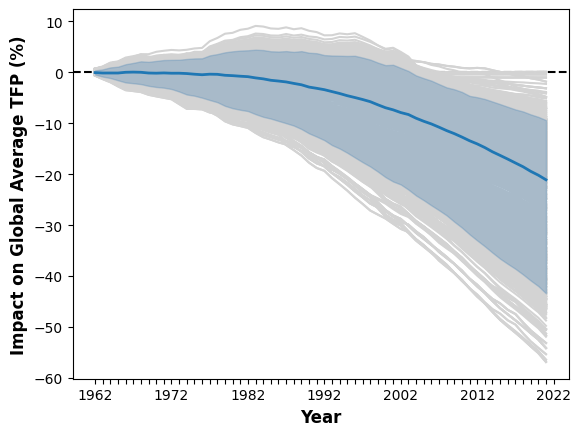

In [114]:
for col in total_impacts_df.columns:
    plt.plot(total_impacts_df[col], color="lightgray", zorder=1)
plt.plot(np.mean(total_impacts_df, axis=1), linewidth=2, zorder=3)
percentile_5 = np.quantile(total_impacts_df, .05, axis=1)
percentile_95 = np.quantile(total_impacts_df, .95, axis=1)
plt.fill_between(list(range(0,60)), percentile_5, percentile_95, color="steelblue", alpha=.3, zorder=2)
plt.axhline(y=0, color="black", linestyle='--', zorder=0)
plt.xlabel("Year", fontweight="bold", size=12)
plt.xticks([i for i in range(0,len(total_impacts_df)+1)],[1962+i if (1960+i) % 10 == 0 else "" for i in range(0,len(total_impacts_df)+1)])
plt.ylabel("Impact on Global Average TFP (%)", fontweight="bold", size=12)
plt.savefig("../figures/ortiz_reproduction.png")